### Integration with MTCNN for Face Mask Detection

The process of face mask detection is orchestrated in two sequential steps: the initial identification of faces in an image, followed by the classification of each detected face based on mask-wearing status.

#### 1. **Integration with MTCNN:**
- **Objective:** This notebook emphasizes the integration of the face mask detection model with the MTCNN face detection algorithm.
- **Process:** Faces are first detected using MTCNN, followed by the classification of each face into categories - 'no mask', 'mask worn incorrectly', or 'with mask', using the trained face mask detection model.

#### 2. **Understanding MTCNN:**
- **Architecture:** MTCNN (Multi-Task Cascaded Convolutional Networks) operates through three stages - Proposal Network, Refine Network, and Output Network.
- **Tasks:** It specializes in face classification, bounding box regression, and facial landmark localization, ensuring precise face detection and feature identification.

#### 3. **Performance Insights:**
- **Efficiency:** Among various face detection models, MTCNN demonstrates superior performance, identifying a higher number of faces with precision.
- **Complementarity:** The combination of MTCNN's accuracy in face detection and the face mask detection model’s classification accuracy promises comprehensive and reliable results.

#### **Operational Highlights:**
- **Sequential Processing:** The synergy of MTCNN’s face detection and the subsequent classification by the face mask detection model ensures a streamlined and efficient operation.
- **Precision & Accuracy:** MTCNN’s ability to accurately detect and delineate facial features enhances the subsequent mask classification’s reliability.
- **Adaptability:** The integration is designed for versatility, capable of being deployed in diverse scenarios for real-time face and mask detection.

#### **Key Takeaways:**
- **Enhanced Detection:** MTCNN’s integration amplifies the model’s face detection capability, setting the stage for accurate mask classification.
- **Comprehensive Approach:** The two-step process, enriched by MTCNN’s precision, ensures a holistic approach to face mask detection.
- **Future Adaptations:** The insights and performance metrics derived from this integration will inform future optimizations and adaptations for enhanced performance.

In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd

import cv2
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.models import load_model

from imutils import paths
import pathlib
import matplotlib.pyplot as plt
import os
import glob

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [2]:
image_path = pathlib.Path('../dataset/images')
annot_path = pathlib.Path('../dataset/annotations')
image_directories = sorted(glob.glob(os.path.join(image_path,"*.png")))
labelPaths = list(sorted(os.listdir(annot_path)))

In [3]:
# Instantiate MTCNN face detector and load in mask detector model
face_detector = MTCNN(min_face_size=15)
model = load_model('face_mask_detector.h5')

In [4]:
# observe MTCNN detection output
original_image = cv2.imread(image_directories[0])
new_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
detected_faces = face_detector.detect_faces(new_image)
detected_faces

1/1 [==============================] - 0s 111ms/step


[{'box': [318, 81, 42, 58],
  'confidence': 0.9989362359046936,
  'keypoints': {'left_eye': (327, 105),
   'right_eye': (348, 102),
   'nose': (339, 117),
   'mouth_left': (332, 127),
   'mouth_right': (349, 124)}},
 {'box': [77, 100, 29, 36],
  'confidence': 0.9970299005508423,
  'keypoints': {'left_eye': (87, 114),
   'right_eye': (101, 114),
   'nose': (95, 121),
   'mouth_left': (89, 130),
   'mouth_right': (100, 130)}},
 {'box': [467, 168, 23, 28],
  'confidence': 0.9577679634094238,
  'keypoints': {'left_eye': (472, 178),
   'right_eye': (481, 177),
   'nose': (475, 184),
   'mouth_left': (473, 191),
   'mouth_right': (480, 191)}}]

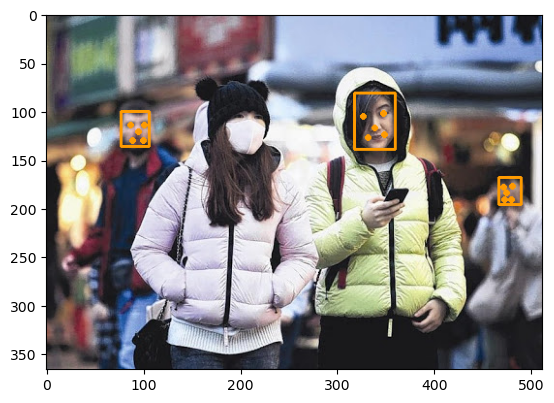

In [5]:
# Observe detections on the image
for i in range(len(detected_faces)):
    bounding_box = detected_faces[i]['box']
    keypoints = detected_faces[i]['keypoints']

    cv2.rectangle(original_image,
                  (bounding_box[0], bounding_box[1]),
                  (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                  (0,155,255),
                  2)

    cv2.circle(original_image,(keypoints['left_eye']), 2, (0,155,255), 2)
    cv2.circle(original_image,(keypoints['right_eye']), 2, (0,155,255), 2)
    cv2.circle(original_image,(keypoints['nose']), 2, (0,155,255), 2)
    cv2.circle(original_image,(keypoints['mouth_left']), 2, (0,155,255), 2)
    cv2.circle(original_image,(keypoints['mouth_right']), 2, (0,155,255), 2)

plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))

In [6]:
detections = []

def detect(img, imageId, min_confidence):
    
    """This function uses the face detector to locate faces in an image at a given confidence minimum.
       Predictions are made using the face mask detector model. Saves image name, label info, and 
       bounding box dimensions to a list for dataframe conversion when looped over, and will 
       produce an image with predictions if run independently."""
    
    original_image = cv2.imread(img)
    new_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    detected_faces = face_detector.detect_faces(new_image)
    (im_h, im_w) = original_image.shape[:2]
    
    for detected_face in detected_faces:
        confidence = detected_face['confidence']
        if confidence >= min_confidence:
            x, y, w, h = detected_face['box']
            (x, y) = (max(0, x), max(0, y))
            (x2, y2) = (min(im_w - 1, x+w), min(im_h - 1, y+h))
            face = new_image[y:y2, x:x2]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = np.expand_dims(face, axis=0)
            face = preprocess_input(face)

            mask_weared_incorrect, with_mask, without_mask = model.predict(face)[0]
            # determine the class label and color we'll use to draw the bounding box and text
            if max([mask_weared_incorrect, with_mask, without_mask]) == with_mask:
                label = 'with_mask'
                color = (0, 255, 0)
            elif max([mask_weared_incorrect, with_mask, without_mask]) == without_mask:
                label = 'without_mask'
                color = (0, 0, 255)
            else:
                label = 'mask_worn_incorrectly'
                color = (255, 0, 0)
            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max([mask_weared_incorrect, with_mask, without_mask]) * 100)
            # display the label and bounding box rectangle on the output frame
            cv2.putText(original_image, label, (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(original_image, (x, y), (x2, y2), color, 2)

            detections.append([img[62:], label, color, x, y, x2,  y2])

            plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
            plt.grid(None)

1/1 [==============================] - 0s 489ms/step


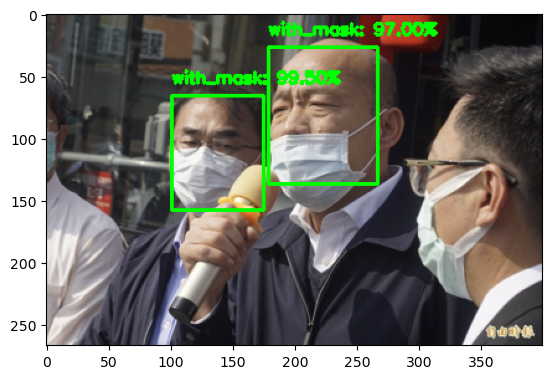

In [7]:
detections = []
for idx,image in enumerate(image_directories):

    original_image = cv2.imread(image)
    imageId = idx
    
    try:
        detect(image, imageId, 0.5)
    except:
        print(f'error with image {image}')

In [8]:
len(detections)

2670

In [9]:
detections_df = pd.DataFrame(detections, columns=['image', 'label', 'color', 'startX', 'startY', 'endX', 'endY'])
detections_df.head()

,image,label,color,startX,startY,endX,endY
0,,without_mask: 99.76%,"(0, 0, 255)",318,81,360,139
1,,without_mask: 46.32%,"(0, 0, 255)",77,100,106,136
2,,without_mask: 79.26%,"(0, 0, 255)",467,168,490,196
3,,with_mask: 99.98%,"(0, 255, 0)",224,30,255,68
4,,with_mask: 99.99%,"(0, 255, 0)",321,28,351,66


In [10]:
detection_count = pd.DataFrame(detections_df.groupby('image')['label'].count())

In [11]:
face_df = pd.read_pickle('face_df.pkl')

In [12]:
face_detection_count_df = pd.merge(face_df, detection_count, on='image', how = 'left')

In [13]:
face_detection_count_df.columns = ['image', 'face_count', 'detected']
face_detection_count_df.fillna(0, inplace=True)
face_detection_count_df['diff'] = face_detection_count_df['face_count'] - face_detection_count_df['detected']

In [14]:
face_detection_count_df.sort_values('diff', ascending=False).head()

,image,face_count,detected,diff
226,,31,2670,-2639
472,,28,2670,-2642
22,,26,2670,-2644
177,,24,2670,-2646
187,,21,2670,-2649


1/1 [==============================] - 0s 460ms/step


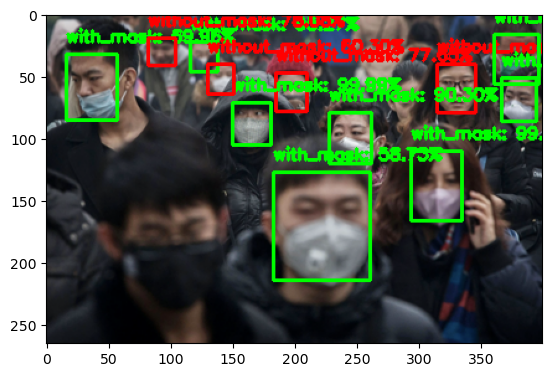

In [20]:
detect('../dataset/images/647.png', 165, 0.5)

In [21]:
face_detection_count_df[face_detection_count_df['diff'] > 0].sum()

image         0
face_count    0
detected      0
diff          0
dtype: object

In [22]:
face_detection_count_df[face_detection_count_df['diff'] < 0].sum()

image                 
face_count        2800
detected       2277510
diff          -2274710
dtype: object

In [23]:
face_detection_count_df[face_detection_count_df['diff'] == 0].sort_values(by='face_count')

,image,face_count,detected,diff
